# **D213 Task 2 | Sentiment Analysis Using Neural Networks**

#### The objective of this analysis is to analyze customer sentiment in their reviews left on Yelp. 
#### We will use a Neural Network model capable of performing text classification that can be trained to produce useful predictions on text sequences in the data set.

## **Import Libraries and Packages. Read in Data.**

In [120]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [121]:
import re
import tensorflow as tf
from tensorflow import keras
from keras import preprocessing

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [122]:
df = pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
copy_df = df.copy()
df.head()

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [123]:
df.columns = ['Review', 'Sentiment']
df.head()

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [124]:
review_length = df.Review.str.len()
print('max review length: ', max(review_length))
print('min review length: ', min(review_length))
print('mean review length: ', review_length.mean())
print('median review length: ', review_length.median())

max review length:  149
min review length:  11
mean review length:  58.316
median review length:  51.0


In [125]:
review_length = pd.DataFrame(data=review_length)
review_length.head()

,Review
0,24
1,18
2,41
3,87
4,59


In [187]:
review_length['Review'].describe()

count    1000.00000
mean       58.31600
std        32.36414
min        11.00000
25%        33.00000
50%        51.00000
75%        80.00000
max       149.00000
Name: Review, dtype: float64

<Axes: xlabel='Review', ylabel='Count'>

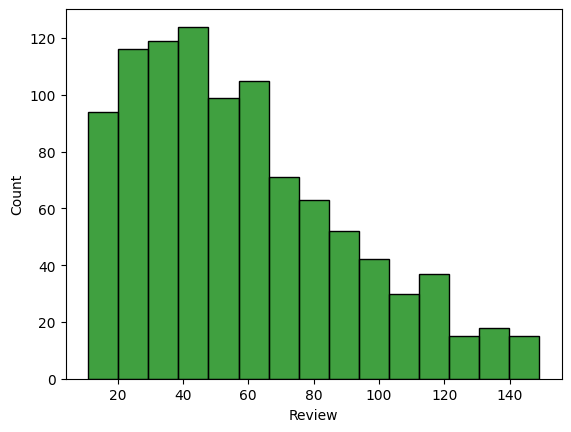

In [126]:
sns.histplot(data=review_length, x='Review', color='green')

## **Data Preprocessing**

### Exploratory Data Analysis

In [127]:
df.shape

(1000, 2)

In [128]:
df.dtypes

Review       object
Sentiment     int64
dtype: object

In [129]:
df.describe(include=object)

,Review
count,1000
unique,996
top,I would not recommend this place.
freq,2


In [130]:
df.isna().sum()

Review       0
Sentiment    0
dtype: int64

In [131]:
df['Sentiment'].value_counts()

Sentiment
1    500
0    500
Name: count, dtype: int64

In [132]:
# issue with countplot. Had to specify hue or color argument for it to even graph.

<Axes: xlabel='Sentiment', ylabel='count'>

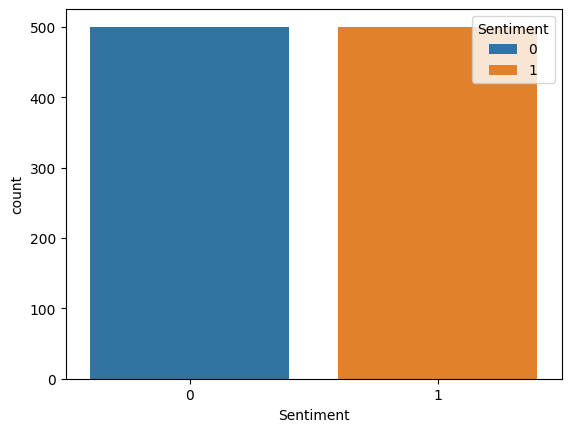

In [133]:
sns.countplot(x='Sentiment', data=df, hue=df['Sentiment'])

The categories of sentiment are equally distributed. 50% Negative (0) and 50% positive (1).

### Character Count

In [134]:
#Inital list of words/characters in reviews
reviews = df['Review']
list_of_chars = []
for comment in reviews:
    for character in reviews:
        if character not in list_of_chars:
            list_of_chars.append(character)
print(list_of_chars)

['Wow... Loved this place.', 'Crust is not good.', 'Not tasty and the texture was just nasty.', 'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.', 'The selection on the menu was great and so were the prices.', 'Now I am getting angry and I want my damn pho.', "Honeslty it didn't taste THAT fresh.)", 'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.', 'The fries were great too.', 'A great touch.', 'Service was very prompt.', 'Would not go back.', 'The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.', 'I tried the Cape Cod ravoli, chicken,with cranberry...mmmm!', 'I was disgusted because I was pretty sure that was human hair.', 'I was shocked because no signs indicate cash only.', 'Highly recommended.', 'Waitress was a little slow in service.', 'This place is not worth your time, let alone Vegas.', 'did not like at all.', 'The Burrittos Bl

In [180]:
def contains_non_english(text):
    # Regular expression pattern to match English characters and common punctuation marks
    pattern = re.compile(r'^[a-zA-Z0-9!@#$%^&*(),.?":{}|<>]+$')
    
    # Check if the text contains non-English characters
    if pattern.match(text):
        return True
    else:
        return False

print(contains_non_english('list_of_chars'))

False


### Removing stop words, unusual characters, tokenization, lemmatization

In [135]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [136]:
nltk.download('punkt')
nltk.data.path.append("/path/to/nltk_data")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [137]:
nltk.download('wordnet')
nltk.data.path.append("/path/to/nltk_data")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaili\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [138]:
description_list = []
stop_words = stopwords.words('english')
for description in df.Review:
    
    #Regular Expression removes puncuation and special characters
    description = re.sub("[^a-zA-Z]", " ", description)
    
    #convert to lowercase
    description = description.lower()
    
    #perform tokenization
    description = nltk.word_tokenize(description)
    
    #perform lemmatization
    lemma = nltk.WordNetLemmatizer()
    decription = [lemma.lemmatize(word) for word in description if word not in stop_words]

    description_list.append(description)

print(description_list)

[['wow', 'loved', 'this', 'place'], ['crust', 'is', 'not', 'good'], ['not', 'tasty', 'and', 'the', 'texture', 'was', 'just', 'nasty'], ['stopped', 'by', 'during', 'the', 'late', 'may', 'bank', 'holiday', 'off', 'rick', 'steve', 'recommendation', 'and', 'loved', 'it'], ['the', 'selection', 'on', 'the', 'menu', 'was', 'great', 'and', 'so', 'were', 'the', 'prices'], ['now', 'i', 'am', 'getting', 'angry', 'and', 'i', 'want', 'my', 'damn', 'pho'], ['honeslty', 'it', 'didn', 't', 'taste', 'that', 'fresh'], ['the', 'potatoes', 'were', 'like', 'rubber', 'and', 'you', 'could', 'tell', 'they', 'had', 'been', 'made', 'up', 'ahead', 'of', 'time', 'being', 'kept', 'under', 'a', 'warmer'], ['the', 'fries', 'were', 'great', 'too'], ['a', 'great', 'touch'], ['service', 'was', 'very', 'prompt'], ['would', 'not', 'go', 'back'], ['the', 'cashier', 'had', 'no', 'care', 'what', 'so', 'ever', 'on', 'what', 'i', 'had', 'to', 'say', 'it', 'still', 'ended', 'up', 'being', 'wayyy', 'overpriced'], ['i', 'tried',

In [139]:
# Removing stopwords

decription = [word for word in description if not word in stop_words]
description = " ".join(description)
description_list.append(description)
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [140]:
# Identify vocabulary size

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  2072


### Length of Reviews

In [141]:
review_len = []
for char in reviews:
    review_len.append(len(char.split(" ")))

review_max = np.max(review_len)
review_min = np.min(review_len)
review_median = np.median(review_len)

print("Max sequence length: ", review_max)
print("Median sequence length: ", review_median)
print("Min sequence length: ", review_min)


Max sequence length:  32
Median sequence length:  10.0
Min sequence length:  1


### Train/Test Split

In [142]:
#splitting the data into training and testing sets

X = np.array(description_list, dtype=object)
y = df.Sentiment.values

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (1001,)
y shape:  (1000,)


In [143]:
min_samples = min(X.shape[0], y.shape[0])
X = X[:min_samples]
y = y[:min_samples]

In [144]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1000,)
y shape: (1000,)


In [145]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 21, stratify = y)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

# view the training and testing sample sizes
print("Training size: ", X_train.shape)
print("Testing size: ", X_test.shape)

Training size:  (800,)
Testing size:  (200,)


### Padding

In [146]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [147]:
padding_type = 'post'  # or 'pre' 
trunc_type = 'post'    # or 'pre' 

# Applying padding to training data
sequences_train = tokenizer.texts_to_sequences(X_train)
padded_train = pad_sequences(sequences_train, maxlen = review_max, padding=padding_type, truncating=trunc_type)

# Applying padding to testing data
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sequences_test, maxlen = review_max, padding=padding_type, truncating=trunc_type)

In [148]:
import sys

In [149]:
# Display the padded sequence

np.set_printoptions(threshold=sys.maxsize)
padded_train[1]

array([   9,   45,    7, 2056,   24,    1,   15, 1722, 2058,  155,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [150]:
# convert padded data to numpy array to be used in model

training_padded = np.array(padded_train)
training_label = np.array(y_train)
test_padded = np.array(padded_test)
test_label = np.array(y_test)

# export to csv

pd.DataFrame(training_padded).to_csv("training_padded.csv")
pd.DataFrame(training_label).to_csv("traning_label.csv")
pd.DataFrame(test_padded).to_csv("test_padded.csv")
pd.DataFrame(test_label).to_csv("test_label.csv")

## **Network Architecture**

In [153]:
# define hyperparameters
activation = 'softmax'
loss = 'sparse_categorical_crossentropy'
optimizer = 'adam'
num_epochs = 20
embedding_dim = 50

# define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)

# define the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(review_max,)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation=activation)
])

# train the model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()
history = model.fit(training_padded, training_label, batch_size=32, epochs=num_epochs,
                    validation_split=0.3, callbacks=[early_stopping_monitor], verbose=True)
                    

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 32, 50)              │         103,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 50)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,852 (444.73 KB)

 Trainable params: 113,852 (444.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4958 - loss: 0.6944 - val_accuracy: 0.4417 - val_loss: 0.6996
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5280 - loss: 0.6882 - val_accuracy: 0.4417 - val_loss: 0.7027
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5370 - loss: 0.6855 - val_accuracy: 0.4833 - val_loss: 0.6955
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6112 - loss: 0.6625 - val_accuracy: 0.5708 - val_loss: 0.6662
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6491 - loss: 0.6416 - val_accuracy: 0.6708 - val_loss: 0.6313
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7724 - loss: 0.5449 - val_accuracy: 0.8250 - val_loss: 0.5241
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9169 - loss: 0.3829 - val_accuracy: 0.7042 - val_loss: 0.5143
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9333 - loss: 0.2412 - val_accuracy: 0.8333 - val_loss

In [154]:
# saving the model
model.save('yelp_SA_model.keras')

yelp_SA_model = load_model('yelp_SA_model.keras')

## **Predictions**

In [157]:
# predictions on training data
predictions_train = yelp_SA_model.predict(training_padded)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


In [158]:
# predictions on testing data
predictions_test = yelp_SA_model.predict(test_padded)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


In [160]:
# verify the predicted sentiment by comparing to actual label from test data
# choose any text from data to verify

i = 9 

print("Predicted Review Text: ", X_test[i], "\n")
print("Predicted: NEGATIVE" if predictions_test[i][0] >= 0.5 else "POSITIVE", "Review")
print("Actual: ", "NEGATIVE" if y_test[i] == 0 else "POSITIVE", "Review")

Predicted Review Text:  ['great', 'place', 'to', 'eat', 'reminds', 'me', 'of', 'the', 'little', 'mom', 'and', 'pop', 'shops', 'in', 'the', 'san', 'francisco', 'bay', 'area'] 

POSITIVE Review
Actual:  POSITIVE Review


In [161]:
# verify the predicted sentiment by comparing to actual label from test data
# choose any text from data to verify

i = 89 

print("Predicted Review Text: ", X_test[i], "\n")
print("Predicted: NEGATIVE" if predictions_test[i][0] >= 0.5 else "POSITIVE", "Review")
print("Actual: ", "NEGATIVE" if y_test[i] == 0 else "POSITIVE", "Review")

Predicted Review Text:  ['check', 'it', 'out'] 

POSITIVE Review
Actual:  POSITIVE Review


In [163]:
# verify the predicted sentiment by comparing to actual label from test data
# choose any text from data to verify

i = 199

print("Predicted Review Text: ", X_test[i], "\n")
print("Predicted: NEGATIVE" if predictions_test[i][0] >= 0.5 else "POSITIVE", "Review")
print("Actual: ", "NEGATIVE" if y_test[i] == 0 else "POSITIVE", "Review")

Predicted Review Text:  ['i', 'think', 'food', 'should', 'have', 'flavor', 'and', 'texture', 'and', 'both', 'were', 'lacking'] 

POSITIVE Review
Actual:  NEGATIVE Review


## **Model Evaluation**

In [165]:
# verify model accuracy on training data
score = model.evaluate(training_padded, training_label, verbose=0)

print(f'Training Loss: {score[0]} | Training Accuracy: {score[1]}')

Training Loss: 0.18936742842197418 | Training Accuracy: 0.9237499833106995


In [166]:
# verify model accuracy on test data
score = model.evaluate(test_padded, test_label, verbose=0)

print(f'Test Loss: {score[0]} | Test Accuracy: {score[1]}')

Test Loss: 0.481830894947052 | Test Accuracy: 0.7799999713897705


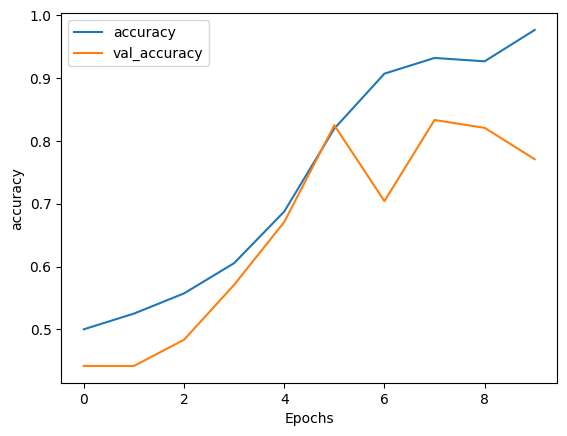

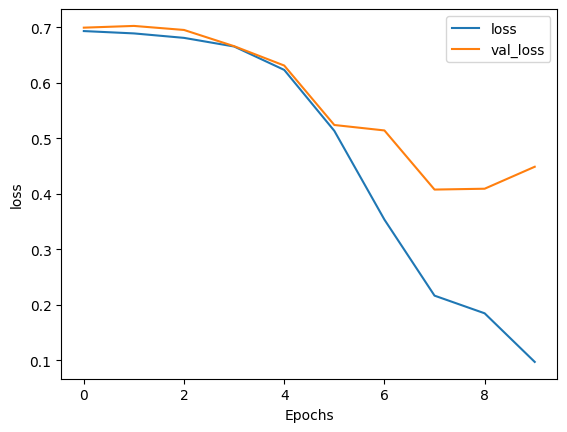

In [167]:
# graph accuracy and loss

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")